In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import shap

In [12]:
batter_woba_df = pd.read_csv("Resources/full_woba_learning.csv")
batter_slg_df = pd.read_csv("Resources/full_slg_learning.csv")
batter_babip_df = pd.read_csv("Resources/full_babip_learning.csv")
batter_wrc_df = pd.read_csv("Resources/full_wrc_learning.csv")
batter_woba_df = batter_woba_df.drop(['z_scores_avg_woba', 'z_scores_avg_slg', 'z_scores_avg_babip', 'z_scores_avg_wrc+'], axis=1)
batter_slg_df = batter_slg_df.drop(['z_scores_avg_woba', 'z_scores_avg_slg', 'z_scores_avg_babip', 'z_scores_avg_wrc+'], axis=1)
batter_babip_df = batter_babip_df.drop(['z_scores_avg_woba', 'z_scores_avg_slg', 'z_scores_avg_babip', 'z_scores_avg_wrc+'], axis=1)
batter_wrc_df = batter_wrc_df.drop(['z_scores_avg_woba', 'z_scores_avg_slg', 'z_scores_avg_babip', 'z_scores_avg_wrc+'], axis=1)

batter_wrc_df

,Age,G,AB,PA,H,1B,2B,3B,HR,R,...,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,avg_wOBA,zscore_difference_wrc+
0,37.666667,126.000000,454.0,502.666667,120.333333,94.000000,15.666667,0.000000,10.666667,38.000000,...,0.438667,351.333333,0.152667,0.268000,0.246000,0.395667,0.307000,-0.766667,0.299333,-0.081495
1,32.666667,127.666667,436.0,483.666667,113.666667,68.666667,29.666667,4.666667,10.666667,48.000000,...,0.422000,341.333333,0.157000,0.266333,0.246000,0.374333,0.303333,1.266667,0.322333,-0.385844
2,34.666667,149.000000,523.0,617.000000,123.000000,77.666667,21.000000,0.333333,24.000000,76.000000,...,0.438667,426.666667,0.166333,0.249000,0.254333,0.446333,0.351333,1.766667,0.327333,-0.496512
3,32.666667,148.000000,532.0,612.333333,131.666667,85.666667,26.666667,1.666667,17.666667,80.000000,...,0.466000,396.000000,0.204333,0.289000,0.253667,0.425333,0.338333,1.733333,0.323667,0.797455
4,30.666667,139.000000,491.0,579.000000,125.666667,72.000000,24.333333,2.333333,27.000000,79.666667,...,0.394333,403.000000,0.168667,0.257000,0.265667,0.458333,0.361333,2.733333,0.360333,-1.282269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,22.000000,110.000000,360.0,404.000000,73.000000,48.000000,16.000000,1.000000,8.000000,38.000000,...,0.414000,263.000000,0.170000,0.275000,0.226000,0.378000,0.305000,-0.900000,0.272000,1.684866
252,25.500000,133.500000,392.0,440.000000,92.000000,59.500000,20.500000,2.500000,9.500000,42.500000,...,0.320500,312.500000,0.210500,0.289500,0.229500,0.338500,0.287000,2.300000,0.291500,1.889214
253,24.000000,72.000000,258.0,298.000000,76.000000,56.000000,10.000000,0.000000,10.000000,25.000000,...,0.469000,226.000000,0.162000,0.228000,0.289000,0.475000,0.374000,1.500000,0.365000,-1.449489
254,24.000000,52.000000,173.0,194.000000,42.000000,28.000000,9.000000,1.000000,4.000000,16.000000,...,0.374000,131.000000,0.131000,0.274000,0.243000,0.450000,0.332000,0.800000,0.302000,-0.855488


In [21]:
def train_and_evaluate_regression_model(df, target_column):
    # Drop rows with missing values
    df.dropna(axis=1, inplace=True)
    
    # Split data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create the XGBoost model
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        max_depth=2,
        learning_rate=0.01,
        n_estimators=500
    )
    
    # Train the XGBoost model
    xgb_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = xgb_model.predict(X_test_scaled)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error: {rmse}")
    
    # Create the SHAP explainer
    explainer = shap.Explainer(xgb_model, X_train_scaled)
    
    # Calculate SHAP values
    shap_values = explainer(X_test_scaled, check_additivity=False)
    
    return {
        "rmse": rmse,
        "shap_values": shap_values,
        "X_test_scaled": X_test_scaled,
        "X_train": X_train,
        "X_train_scaled": X_train_scaled,
        "y_pred": y_pred,
        "y_test": y_test
    }

In [20]:
result_woba = train_and_evaluate_regression_model(batter_woba_df, 'zscore_difference_woba')

Root Mean Squared Error: 1.0564801449978556


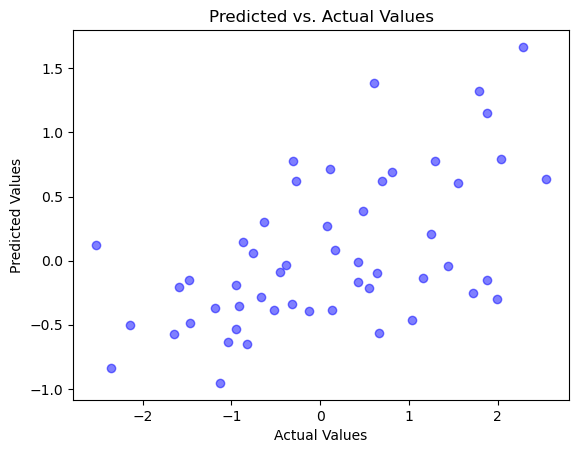

In [5]:
plt.scatter(result_woba['y_test'], result_woba['y_pred'], color='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

In [6]:
result_slg = train_and_evaluate_regression_model(batter_slg_df, 'zscore_difference_slg')

Root Mean Squared Error: 1.0540421349098994
RMSE: 1.0540421349098994


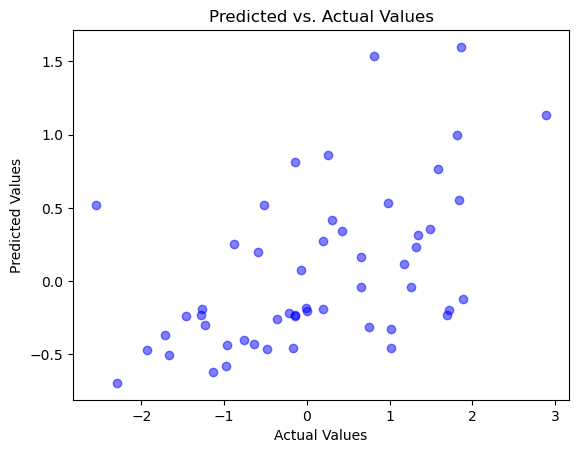

In [7]:
plt.scatter(result_slg['y_test'], result_slg['y_pred'], color='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

In [8]:
result_babip = train_and_evaluate_regression_model(batter_babip_df, 'zscore_difference_babip')

Root Mean Squared Error: 1.2303329158077527
RMSE: 1.2303329158077527


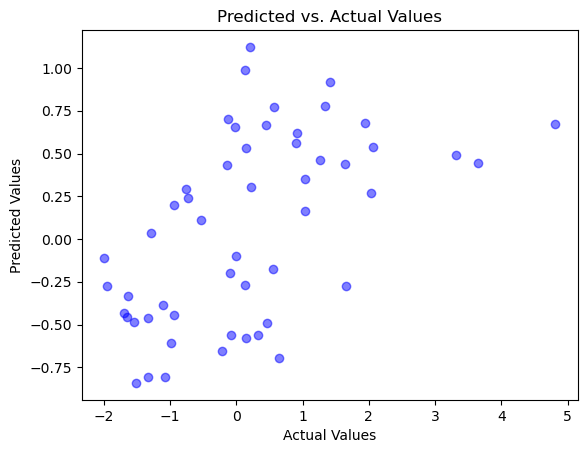

In [9]:
plt.scatter(result_babip['y_test'], result_babip['y_pred'], color='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

In [10]:
result_wrc = train_and_evaluate_regression_model(batter_wrc_df, 'zscore_difference_wrc+')

Root Mean Squared Error: 1.006769270616956
RMSE: 1.006769270616956


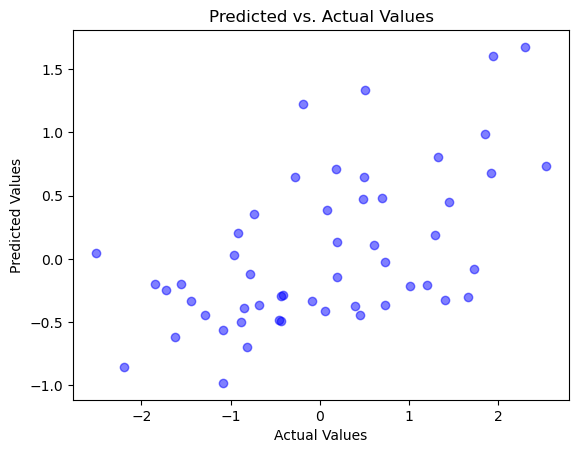

In [11]:
plt.scatter(result_wrc['y_test'], result_wrc['y_pred'], color='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.72      0.63        25
           1       0.65      0.48      0.55        27

    accuracy                           0.60        52
   macro avg       0.61      0.60      0.59        52
weighted avg       0.61      0.60      0.59        52



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
